## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`.

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2023-04-06 17:48:49--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71,53K  --.-KB/s    in 0,01s   

2023-04-06 17:48:49 (5,50 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [9]:
df = pd.read_csv("AER_credit_card_data.csv")
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [10]:
list(df)

['card',
 'reports',
 'age',
 'income',
 'share',
 'expenditure',
 'owner',
 'selfemp',
 'dependents',
 'months',
 'majorcards',
 'active']

In [11]:
df.card = (df.card == 'yes').astype(int)
df.owner = (df.owner == 'yes').astype(int)
df.selfemp = (df.selfemp == 'yes').astype(int)

In [12]:
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,1,0,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,0,0,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,1,0,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,0,0,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,1,0,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,1,0,33.58333,4.5660,0.002146,7.333333,1,0,0,94,1,19
1315,0,5,23.91667,3.1920,0.000376,0.000000,0,0,3,12,1,5
1316,1,0,40.58333,4.6000,0.026513,101.298300,1,0,2,1,1,2
1317,1,0,32.83333,3.7000,0.008999,26.996670,0,1,0,60,1,7


In [34]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

### $Ans = share$


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [25]:
numerical = ['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'owner',
 'selfemp',
 'dependents',
 'months',
 'majorcards',
 'active']

In [43]:
print(X_train.shape, y_train.shape)

# temp = df_train[["reports","age"]]
temp = ['reports','age','income','share','expenditure','owner','selfemp','dependents','months','majorcards','active']

(791, 11) (791,)


In [49]:
for i in temp:

    if roc_auc_score(y_train, df_train[i]) < 0.5:
        print("%s:"%i,roc_auc_score(y_train, -df_train[i]))
    else:
        print("%s:"%i,roc_auc_score(y_train, df_train[i]))

reports: 0.7166629860689376
age: 0.5240020979407055
income: 0.5908049467233478
share: 0.989183643423692
expenditure: 0.991042345276873
owner: 0.5856751136384548
selfemp: 0.5097995914536521
dependents: 0.5327757227773791
months: 0.5294217780967629
majorcards: 0.5343859842838476
active: 0.6043173411362006


In [50]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [51]:
val_dict = df_val[numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.9696969696969697

In [52]:
roc_auc_score(y_val, y_pred)

0.9949923991773226

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

## $$ Ans \approx 0.995 $$

In [53]:
t = np.arange(0,1,0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

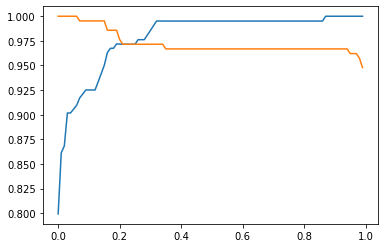

In [60]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = np.arange(0,1,0.01)

pre =[]
rec = []

for i in t:
    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    pre.append(p)
    rec.append(r)


plt.plot(t,pre)
plt.plot(t,rec)

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

## $$ Ans \approx 0.3 $$

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

## $$ Ans \approx 0.4 $$

In [61]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = np.arange(0,1,0.01)

pre =[]
rec = []
f1_score = []
for i in t:
    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2*(p*r)/(p+r)

    f1_score.append((i,f1))

    pre.append(p)
    rec.append(r)

In [63]:
score = 0

best_score = None
for i in f1_score:
    
    if i[1] > score:
        score = i[1]
        best_score = i

In [64]:
best_score

(0.32, 0.9832134292565947)

In [65]:
f1_score

[(0.0, 0.8884210526315789),
 (0.01, 0.9254385964912281),
 (0.02, 0.9295154185022027),
 (0.03, 0.9483146067415731),
 (0.04, 0.9483146067415731),
 (0.05, 0.9504504504504505),
 (0.06, 0.9525959367945824),
 (0.07, 0.9545454545454546),
 (0.08, 0.9567198177676538),
 (0.09, 0.958904109589041),
 (0.1, 0.958904109589041),
 (0.11, 0.958904109589041),
 (0.12, 0.958904109589041),
 (0.13, 0.9633027522935779),
 (0.14, 0.9677419354838711),
 (0.15, 0.9722222222222221),
 (0.16, 0.9742388758782201),
 (0.17, 0.9765258215962441),
 (0.18, 0.9765258215962441),
 (0.19, 0.9788235294117645),
 (0.2, 0.9739952718676123),
 (0.21, 0.9715639810426541),
 (0.22, 0.9715639810426541),
 (0.23, 0.9715639810426541),
 (0.24, 0.9715639810426541),
 (0.25, 0.9715639810426541),
 (0.26, 0.9738717339667459),
 (0.27, 0.9738717339667459),
 (0.28, 0.9738717339667459),
 (0.29, 0.9761904761904763),
 (0.3, 0.9785202863961814),
 (0.31, 0.9808612440191389),
 (0.32, 0.9832134292565947),
 (0.33, 0.9832134292565947),
 (0.34, 0.983213429256

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

## $$ Ans \approx 0.003 $$

In [68]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % ("1.0", np.mean(scores), np.std(scores)))

C=1.0 0.996 +- 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## $$ C = 10 $$

In [72]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.989 +- 0.007
C=0.01 0.992 +- 0.006
C=0.1 0.994 +- 0.005
C=0.5 0.996 +- 0.003
C=1 0.996 +- 0.003
C=5 0.997 +- 0.003
C=10 0.997 +- 0.003
